
## **Yelp Dataset Analysis**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset). We explore machine learning tasks in the context of a real-world data set using big data analysis tools.

We have chosen a subset of the Yelp academic dataset for you to work with. This subsampled data is loaded into RDDs in part (0). The complete dataset is available from Yelp's website [here](https://www.yelp.com/dataset).


# ** Part 0: Load the datasets required for the project **

We will load four datasets for this project. In addition to the four datasets, we will also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

In [ ]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.9-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "40g") \
    .getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents,  numSlices=1000)
    return rdd

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [ ]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/ocean/projects/cie170025p/shared/data/yelp_academic_dataset_business.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

61184
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [ ]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/ocean/projects/cie170025p/shared/data/yelp_academic_dataset_user.json')
print (users_rdd.count())
print (users_rdd.take(2))

366715
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [ ]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/ocean/projects/cie170025p/shared/data/yelp_academic_dataset_checkin.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

45166
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [ ]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/ocean/projects/cie170025p/shared/data/yelp_academic_dataset_review_pittsburgh.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

62608
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, we will load two lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [ ]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/ocean/projects/cie170025p/shared/data/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/ocean/projects/cie170025p/shared/data/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

Performing some exploratory analysis is a great step toward understanding the data before building any statistical machine learning models on it.



In [ ]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  61184
Number of users:  366715
Number of checkins:  45166
Number of reviews:  62608


** Question1: ** Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [ ]:

businesses = businesses_rdd.flatMap(lambda x:x['categories']).map(lambda x: (x,1))
business_count = businesses.reduceByKey(lambda x,y: x+y).map(lambda x: (x[1],x[0])).sortByKey(False)
print(business_count.take(5))

[(21892, 'Restaurants'), (8919, 'Shopping'), (7862, 'Food'), (4738, 'Beauty & Spas'), (4340, 'Nightlife')]


** Question2: ** Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [ ]:

cities = businesses_rdd.map(lambda x:x['city']).map(lambda x:(x,1))
city_count = cities.reduceByKey(lambda x,y:x+y).map(lambda x:(x[1],x[0])).sortByKey(False)
print(city_count.take(5))

[(13601, 'Las Vegas'), (8410, 'Phoenix'), (4224, 'Charlotte'), (4039, 'Scottsdale'), (3031, 'Edinburgh')]


** Question3: ** Plot the histogram of stars received by businesses.

Text(0, 0.5, 'Number of Businesses')

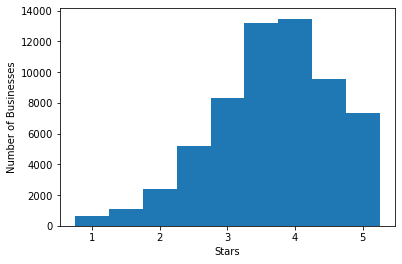

In [ ]:


businesses_stars_counts = businesses_rdd.map(lambda x:(x['stars'])).collect()
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')

** Question4: ** Plot the histogram of number of reviews received by businesses.

Text(0, 0.5, 'Number of Businesses')

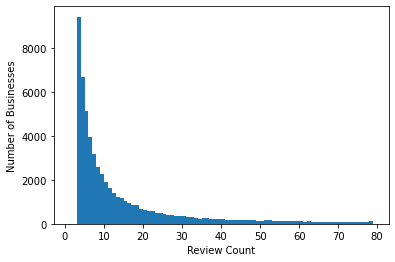

In [ ]:


businesses_review_counts = businesses_rdd.map(lambda x:(x['review_count'])).collect()

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question5: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, we observe a power law relationship in the plot below due to the long-tail. This indicates that reviews for bigger businesses are less in number while for smaller businesses they're higher in number since there are more number of smaller businesses than the big, established ones.

Text(0, 0.5, 'Number of Businesses')

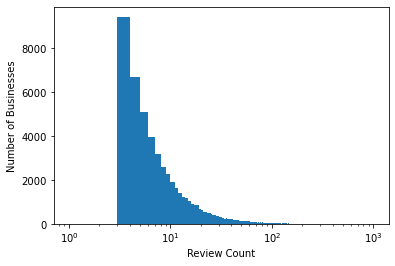

In [ ]:


plt.hist(businesses_review_counts, bins=range(1,1000))
plt.xscale("log")
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question6: ** Plot the histogram of number of reviews written by users.

Text(0, 0.5, 'Number of Users')

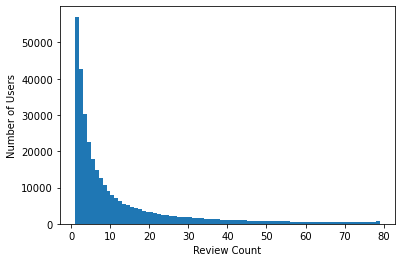

In [ ]:


users_review_counts = users_rdd.map(lambda x:x['review_count']).collect()

plt.hist(users_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question7: ** Plot the above histogram but now on a log-log scale using `bins=range(1,1000)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, the plot below follows a power law relationship as we can observe a long-tail. We can infer that users who will give more reviews will be lesser than users who will give lesser reviews for the businesses.

Text(0, 0.5, 'Number of Users')

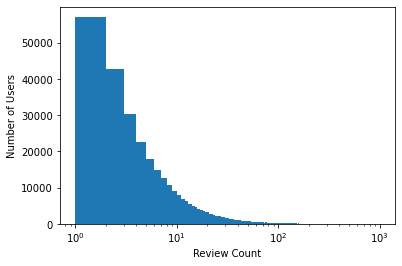

In [ ]:


plt.hist(users_review_counts, bins=range(1,1000))
plt.xscale("log")
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question8: ** Plot the histogram of number of friends a Yelp user has.

Text(0, 0.5, 'Number of Users')

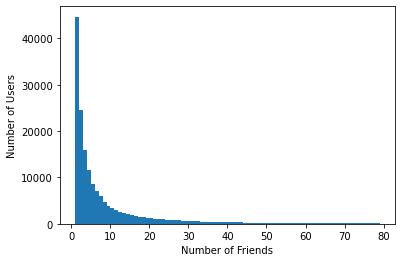

In [ ]:


user_friend_counts = users_rdd.map(lambda x: len(x['friends'])).collect()

plt.hist(user_friend_counts, bins=range(1,80))
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question9: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, we observe a Power Law in the histogram below but it's tail is small compared to other long-tailed graphs we observed. We can infer that very small number of users have higher number of friends while most of them have lesser friends on Yelp.

Text(0, 0.5, 'Number of Users')

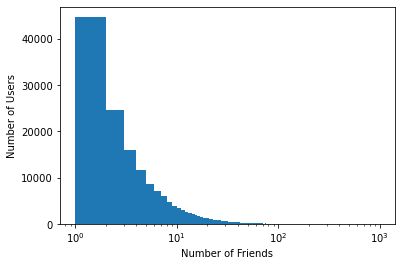

In [ ]:


plt.hist(user_friend_counts, bins=range(1,1000))
plt.xscale("log")
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question10: ** Plot the histogram of number of fans a Yelp user has.

Text(0, 0.5, 'Number of Users')

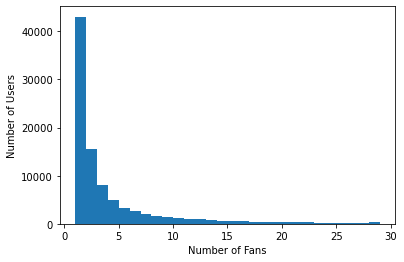

In [ ]:


users_fan_counts = users_rdd.map(lambda x: x['fans']).collect()

plt.hist(users_fan_counts, bins=range(1,30))
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question11: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** Yes, we observe a Power Law relationship but not that strong as it's tail isn't that long compared to an ideal Power Law graph. We can infer that very less number of users have extremely high fan count like famous celebrities while most of the users have lesser fans.

Text(0, 0.5, 'Number of Users')

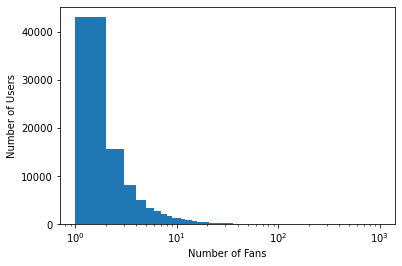

In [ ]:


plt.hist(users_fan_counts, bins=range(1,1000))
plt.xscale("log")
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question12: ** Plot the histogram of number of checkins per Yelp business.

Text(0, 0.5, 'Number of Businesses')

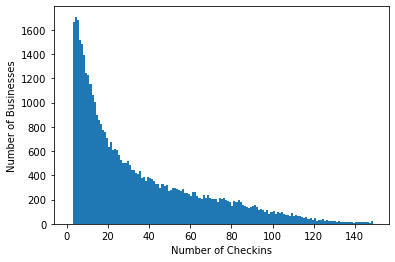

In [ ]:


business_checkin_counts = checkins_rdd.map(lambda x:len(x['checkin_info'])).collect()

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question13: ** Plot the above histogram but now on a log-log scale using `bins=range(3,200)`. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** No, we do not observe a Power Law relationship in the following graph as there is no long-tail towards the end in this graph. An ideal Power Law graph has 95% of the data clustered in the start of the graph followed by a long tail indicating the number of Yelp businesses and checkins do not follow a Power Law distribution. The number of checkins are in the range of 0 to 200 only without any long tail extension.

Text(0, 0.5, 'Number of Businesses')

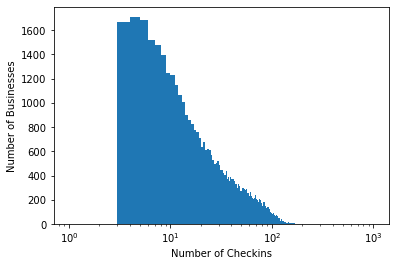

In [ ]:


plt.hist(business_checkin_counts, bins=range(1,1000))
plt.xscale("log")
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question14: ** Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. Fill in the code required to carry out these steps.

In [ ]:


max_checkin_count = checkins_rdd.map(lambda x: len(x['checkin_info'])).max()
business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda x: len(x['checkin_info'])==max_checkin_count) \
    .map(lambda x: x['business_id']).collect()
len(business_ids_with_max_checkins)

41

In [ ]:


business_names_with_max_checkins = businesses_rdd \
    .filter(lambda x: x['business_id'] in business_ids_with_max_checkins) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('Charlotte Douglas International Airport', 'Charlotte'),
 ('Phoenix Sky Harbor International Airport', 'Phoenix'),
 ('Pho Kim Long', 'Las Vegas'),
 ('McCarran International Airport', 'Las Vegas'),
 ('The California Hotel & Casino', 'Las Vegas'),
 ('Golden Nugget Hotel & Casino', 'Las Vegas'),
 ('Rio All Suites Hotel & Casino', 'Las Vegas'),
 ('24 Hour Fitness', 'Las Vegas'),
 ('Excalibur Hotel', 'Las Vegas'),
 ('Ellis Island Casino & Brewery', 'Las Vegas'),
 ('Las Vegas Athletic Club', 'Las Vegas'),
 ('Orleans Hotel & Casino', 'Las Vegas'),
 ('Palms Casino Resort', 'Las Vegas'),
 ('Bellagio Hotel', 'Las Vegas'),
 ('New York - New York', 'Las Vegas'),
 ('Paris Las Vegas Hotel & Casino', 'Las Vegas'),
 ('Monte Carlo Hotel And Casino', 'Las Vegas'),
 ('The Venetian Resort Hotel Casino', 'Las Vegas'),
 ('The Mirage', 'Las Vegas'),
 ('MGM Grand Hotel', 'Las Vegas'),
 ('Treasure Island, LLC', 'Las Vegas'),
 ('The Peppermill Restaurant & Fireside Lounge', 'Las Vegas'),
 ('Flamingo Las Vegas

** Question15: ** Why do you think the above list sees much higher checkins than other businesses in the dataset?

** Answer: ** The above list sees much higher checkins than other businesses could be due to their location. Most of them are located in Las Vegas which is one of the popular tourist spot. They could also be offering some good food with deals or have other attractive activities like casinos, shows etc in them.

** Question16: ** Plot a histogram of the stars associated with business reviews.

Text(0, 0.5, 'Number of Reviews')

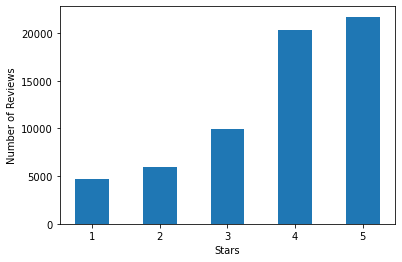

In [ ]:


review_stars_counts = reviews_rdd.map(lambda x: x['stars']).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

** Question17: ** Plot a histogram of the number of reviews written per Yelp user.

Text(0, 0.5, 'Number of Users')

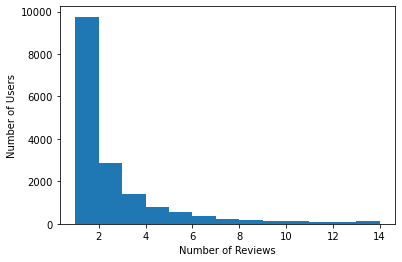

In [ ]:


user_review_counts = list(reviews_rdd.map(lambda x: x['user_id']).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

** Question18: ** Plot a histogram of the number of reviews written per Yelp business.

Text(0, 0.5, 'Number of Businesses')

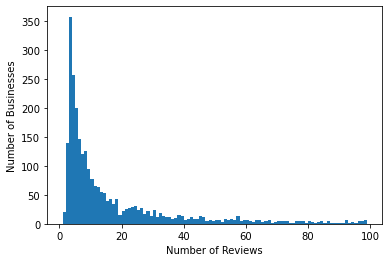

In [ ]:


business_review_counts = list(reviews_rdd.map(lambda x: x['business_id']).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

In [ ]:
reviews_rdd.take(1)

[{'votes': {'funny': 3, 'useful': 7, 'cool': 7},
  'user_id': 'JbAeIYc89Sk8SWmrBCJs9g',
  'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww',
  'stars': 5,
  'date': '2013-06-10',
  'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!",
  'type': 'review',
  'business_id': 'HZdLhv6COCleJMo7nPl-RA'}]

** Question19: ** Plot a histogram of the number of useful votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

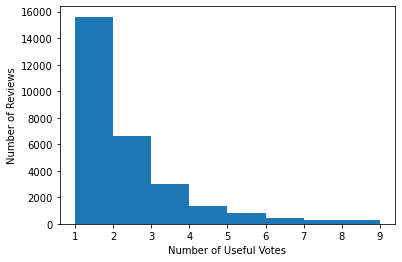

In [ ]:


review_useful_counts = reviews_rdd.map(lambda x:x['votes']).map(lambda x:x['useful']).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

** Question20: ** Plot a histogram of the number of funny votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

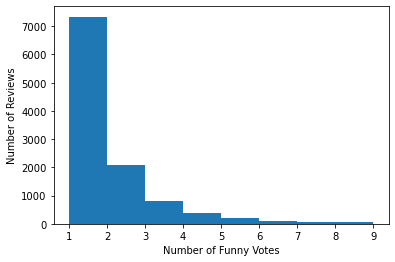

In [ ]:


review_funny_counts = reviews_rdd.map(lambda x:x['votes']).map(lambda x:x['funny']).collect()

plt.hist(review_funny_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

** Question21: ** Plot a histogram of the number of cool votes received by Yelp reviews.

Text(0, 0.5, 'Number of Reviews')

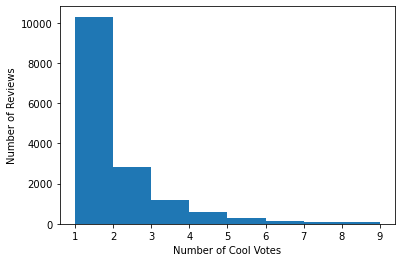

In [ ]:


review_cool_counts = reviews_rdd.map(lambda x:x['votes']).map(lambda x:x['cool']).collect()

plt.hist(review_cool_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

** Question22: ** Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

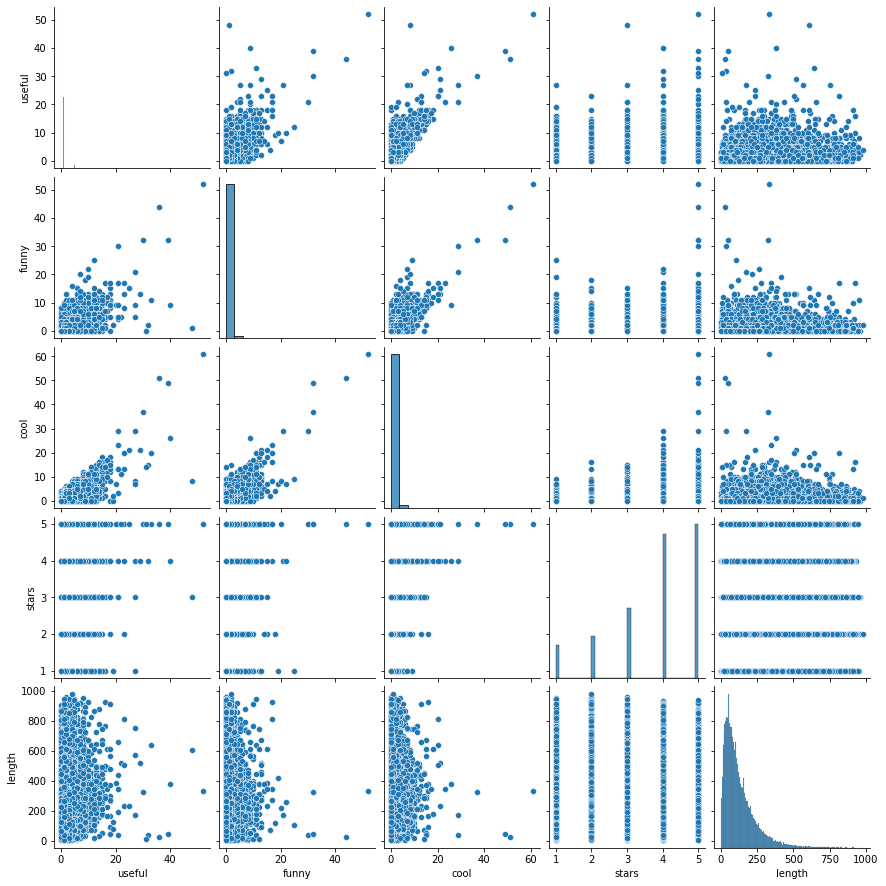

In [ ]:


review_votes_length = reviews_rdd.map(lambda x: (x['votes']['useful'],x['votes']['funny'],x['votes']['cool'],x['stars'],len(x['text'].split()))).collect()
review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

** Question23: ** Let us plot the distribution of the number of words used by males and females in their reviews. We will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [ ]:


male_users = users_rdd.filter(lambda x: x['name'] in male_names)
female_users = users_rdd.filter(lambda x: x['name'] in female_names)

male_user_ids = male_users.map(lambda x: x['user_id']).collect()
female_user_ids = female_users.map(lambda x:x['user_id']).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

166682
174869
366715


** Question24: ** We can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [ ]:


male_reviews = reviews_rdd.filter(lambda x: x['user_id'] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda x: x['user_id'] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda x:len(x.split()))
female_word_count = female_reviews.map(lambda x: len(x.split()))

print ('Male and female review length averages: ', male_word_count.mean(), female_word_count.mean())

Male and female review length averages:  127.3470787972136 139.21062276751053


** Question25: ** The code below calculates the distributions of review lengths for males and female reviewers and plots them. Do you see a marked difference between the average review length of male and female reviewers? Are there any major trends or differences between the distributions of review length of male and female reviewers?

** Answer: ** The number of reviewers for review word count upto 375 has more contribution from female reviewers as observed from the graph. For initial reviews (90 average word length), male reviewers tend to write higher number of reviews(as seen from the blue lines above orange). Though after 90 word length unitl 375, female reviewers tend to write more. After 375 word length, the word count of the reviews are almost similar. Additionally, the curve tends to follow Power Law as it has a long tail after a peak in the start indicating there are lesser reviewers who write long reviews and more reviewers who write short reviews.

In [ ]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

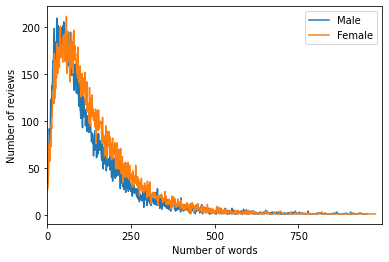

In [ ]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, we will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [ ]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

** Question1: ** Fill in the necessary code to calculate word counts from text reviews below.

In [ ]:


max_words = 30000

all_reviews = reviews_rdd.map(lambda x : (x['text'], x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda x:x[0].split()).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  30000


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [ ]:


word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Fill in the required code below to obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [ ]:

from collections import Counter
doc_vectors = all_reviews.map(lambda x: (x[1], x[0].split())).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))
doc_vectors = doc_vectors.map(lambda x: LabeledPoint(x[0],SparseVector(num_unique_words,dict(Counter(x[1])))))
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[LabeledPoint(3.0, (30000,[0,1,2,4,6,8,9,12,13,15,16,19,20,25,38,42,49,58,86,107,114,125,164,168,189,204,208,233,297,301,344,352,364,365,465,471,490,669,684,767,781,942,1003,1014,1106,1148,1360,1912,2283,2414,2960,3413,3958,4179,4356,4423,4779,4806,4968,5327,5743,6021,6022,6057,6268,9594,14463,14848,15307,16821,16822,17427,26734],[8.0,3.0,1.0,5.0,5.0,1.0,1.0,1.0,2.0,4.0,6.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (30000,[0,4,5,8,9,17,19,35,36,41,45,55,71,77,87,99,101,132,201,239,306,316,326,331,364,367,377,446,471,607,610,649,914,939,994,2960,3542,6587,6709,10548,15761,18035,20358],[2.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))

** Question4: ** Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [ ]:


doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit(weights=[0.8,0.2])

** Question5: ** Let us implement the baseline predictor which always outputs the most common value of funny votes. Fill in appropriate code.

In [ ]:


most_common_prediction = doc_vectors_train.map(lambda x: (x.label,1)).reduceByKey(lambda x,y:x+y).map(lambda x:(x[1],x[0]))\
                         .sortByKey(False).map(lambda x:x[1]).take(1)[0]

labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 1.2262937962070073
Learned baseline prediction:  0.0


** Question6: ** Let us now use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression.

In [ ]:


dt_model = DecisionTree.trainRegressor(doc_vectors_train,maxDepth=5,categoricalFeaturesInfo={})

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

Validation Root Mean Squared Error (Decision Tree) = 0.7459508019068113
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 35 nodes
  If (feature 24056 <= 0.5)
   If (feature 4 <= 4.5)
    If (feature 2138 <= 1.5)
     If (feature 5 <= 2.5)
      If (feature 2570 <= 1.5)
       Predict: 0.1921811619662078
      Else (feature 2570 > 1.5)
       Predict: 12.5
     Else (feature 5 > 2.5)
      If (feature 33 <= 6.5)
       Predict: 0.38892377244757004
      Else (feature 33 > 6.5)
       Predict: 9.333333333333334
    Else (feature 2138 > 1.5)
     If (feature 44 <= 0.5)
      If (feature 3 <= 1.5)
       Predict: 0.0
      Else (feature 3 > 1.5)
       Predict: 3.0
     Else (feature 44 > 0.5)
      Predict: 44.0
   Else (feature 4 > 4.5)
    If (feature 7214 <= 1.5)
     If (feature 29916 <= 0.5)
      If (feature 146 <= 0.5)
       Predict: 0.5192457016084304
      Else (feature 146 > 0.5)
       Predict: 0.953168044077135
     Else (feature 29916 > 0.5)
      I

** Question7: ** Let us now use a Random Forest ensemble to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression. Build a random forest regressor with 10 trees.

In [ ]:


rf_model = RandomForest.trainRegressor(doc_vectors_train,numTrees = 10, maxDepth=5,categoricalFeaturesInfo={})

predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

Validation Root Mean Squared Error (Random Forest) = 0.7403807049182749
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 11343 <= 1.5)
     If (feature 2 <= 5.5)
      If (feature 940 <= 1.5)
       If (feature 9675 <= 1.5)
        If (feature 24544 <= 0.5)
         Predict: 0.23074558819762825
        Else (feature 24544 > 0.5)
         Predict: 7.25
       Else (feature 9675 > 1.5)
        Predict: 15.0
      Else (feature 940 > 1.5)
       If (feature 0 <= 4.5)
        Predict: 0.0
       Else (feature 0 > 4.5)
        Predict: 20.0
     Else (feature 2 > 5.5)
      If (feature 1791 <= 3.5)
       If (feature 23252 <= 0.5)
        If (feature 23778 <= 0.5)
         Predict: 0.5915582067968185
        Else (feature 23778 > 0.5)
         Predict: 13.0
       Else (feature 23252 > 0.5)
        Predict: 14.0
      Else (feature 1791 > 3.5)
       Predict: 32.0
    Else (feature 11343 > 1.5)
     Predict: 52.0
  Tree 1:
    If (feature 4 <

** Question8: ** Let us now use a Gradient Boosting Trees (GBT) ensemble to predict the number of funny votes. Set the maximum number of iterations to 10. Does this affect the number of trees in the ensemble? Do we need to set the maximum depth of trees in the ensemble? Why or why not?

** Answer: ** By setting the number of iterations to 10, this means the Gradient Bossting Trees will run 10 times. This doesn't affect the number of trees in the ensemble. Yes, we need to set the maximum depth of the trees in the ensemble otherwise it will overfit and perform poorly on the unseen the data. Without a maximum depth size, the base learners will not be weak as needed. Though, the default max_depth of Gradient boosted trees is 3 so it works without explicitly specifying it.

In [ ]:


gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train, numIterations=10,categoricalFeaturesInfo={})

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

Validation Root Mean Squared Error (Gradient Boosting Trees) = 0.7358175384949524
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 24056 <= 0.5)
     If (feature 4 <= 4.5)
      If (feature 2138 <= 1.5)
       Predict: 0.23339358912340555
      Else (feature 2138 > 1.5)
       Predict: 10.0
     Else (feature 4 > 4.5)
      If (feature 7214 <= 1.5)
       Predict: 0.5941654357459379
      Else (feature 7214 > 1.5)
       Predict: 32.0
    Else (feature 24056 > 0.5)
     If (feature 2677 <= 0.5)
      If (feature 36 <= 0.5)
       Predict: 5.333333333333333
      Else (feature 36 > 0.5)
       Predict: 0.0
     Else (feature 2677 > 0.5)
      If (feature 0 <= 2.5)
       Predict: 32.0
      Else (feature 0 > 2.5)
       Predict: 52.0
  Tree 1:
    If (feature 27770 <= 0.5)
     If (feature 146 <= 0.5)
      If (feature 8 <= 3.5)
       Predict: -0.09535203928987485
      Else (feature 8 > 3.5)
       Predict: 0.32063953806008694
     Els

** Question9: ** Which of the four methods we tried gave the best validation RMSE results? 

** Answer: ** Gradient Boosting Trees give the best validation RMSE results - 0.735 (the least amongst all). Hence, it is able to predict the number of funny votes on the Yelp reviews more accurately.  

# ** Part 3: Collaborative filtering for recommendation **

In this section, we will tackle a [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) task which can be used to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [ ]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

** Question1: ** Let us first determine the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices. Fill in the required code to build these dictionaries below.

In [ ]:


review_user_ids = reviews_rdd.map(lambda x: x['user_id']).distinct().collect()
review_business_ids = reviews_rdd.map(lambda x: x['business_id']).distinct().collect()

user_to_index_dict = {review_user_ids[i]:i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]:i for i in range(len(review_business_ids))}

** Question2: ** Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [ ]:


ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x['user_id']], business_to_index_dict[x['business_id']], x['stars']))
print(ratings_rdd.take(2))

[Rating(user=15903, product=910, rating=5.0), Rating(user=11610, product=910, rating=2.0)]


** Question3: ** Let us randomly split data into 80% train and 20% validation set.

In [ ]:


ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit([0.8,0.2])

** Question4: ** For a succession of ranks, we will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). We will use the model to obtain train as well as validation RMSE for each rank. In the cell below, you can fill in the code to carry out the model-building, prediction, and RMSE calculation.

In [ ]:


numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_rdd_train,rank,iterations=numIterations)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

Root Mean Squared Error (rank=1) = Train 2.4118501787688444, Validation 10.887848783179598
Root Mean Squared Error (rank=2) = Train 0.7307324074692422, Validation 2.9092298350879213
Root Mean Squared Error (rank=3) = Train 0.6255490690471001, Validation 2.5809347741948163
Root Mean Squared Error (rank=4) = Train 0.531465954696533, Validation 2.3135011068602878
Root Mean Squared Error (rank=5) = Train 0.512365289423873, Validation 2.48793065730135
Root Mean Squared Error (rank=6) = Train 0.44872528516731247, Validation 2.282771095714718
Root Mean Squared Error (rank=7) = Train 0.4071248879719336, Validation 2.2059068217631115
Root Mean Squared Error (rank=8) = Train 0.3775727238222933, Validation 2.186802056511547
Root Mean Squared Error (rank=9) = Train 0.3548101849692834, Validation 2.212354674116047
Root Mean Squared Error (rank=10) = Train 0.3256252031819768, Validation 2.1796442359147594
Root Mean Squared Error (rank=11) = Train 0.30944374896395865, Validation 2.1453983884972043
Ro

** Question5: ** Let us plot the train and validation RMSE versus the rank. The code below does this for you. Based on this plot, what would your choice of the rank hyperparameter be? Is this choice conclusive or do we need to conduct a more extensive hyperparameter search at larger ranks than the ones we have evaluated?

** Answer: ** The choice of the rank hyperparameter according to the plot below is around 24 and onwards as that's when the validation RMSE curve plateaus. Yes, this choice is conclusive as we can observe that after 24th rank, the curve plateaus for the higher ranks. From the values printed above, we can see that from rank 80 onwards there's change in hundredth decimal place of RMSE which is very minute and changes between rank 20, 40 and 60 are little too.

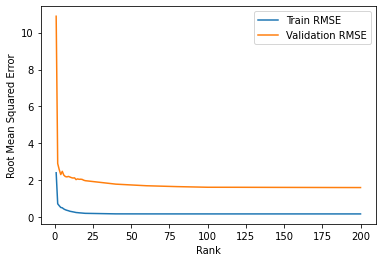

In [ ]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Topic modeling for text reviews **

In this section, we will build and examine a Bayesian topic model named [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). The goal of textual topic modeling is to discover latent topics whose mixtures generate textual documents through a stylized probabilistic generatve model. The topics often have semantic meaning. They may be associated with various aspects discussed in the text corpus such as politics, health, education, etc. Topic models are unsupervised machine learning algorithms. Hence, the nature of discovered topics is entirely dependent of the context of your dataset.

In [ ]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

** Question1: ** Let us create a new RDD of just textual reviews from reviews_rdd, obtain word counts, and build a list of unique words that do not include stop words. Use num_stop_words as a measure of how many of the most frequent words to filter out.

In [ ]:


# number of stopwords i.e. most frequent words to remove
# removal of stopwords such as a, the, from, etc. that occur across a vast majority of documents improves topic models
num_stop_words = 1000

all_reviews = reviews_rdd.map(lambda x: x['text'])
word_counts = list(all_reviews.flatMap(lambda x: x.lower().split()).map(lambda x: (x,1)).countByKey().items())
# sort words in descending order of frequency
word_counts = sorted(word_counts, key=lambda x: -x[1]) 

# remove stopwords
unique_words = [x[0] for x in word_counts[num_stop_words:]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  192742


** Question2: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [ ]:


word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question3: ** Construct an RDD of SparseVectors. Each SparseVector is built using the word counts of a review. Hence, the RDD of SparseVectors should be obtained as a map from the RDD of document word counts.

In [ ]:

from collections import Counter

doc_vectors = all_reviews.map(lambda x: x.lower().split()).map(lambda x: [word_to_index_dict[w] for w in x if w in word_to_index_dict])
doc_vectors = doc_vectors.map(lambda x: SparseVector(num_unique_words,dict(Counter(x))))

# zipWithIndex result needs a minor transform to be acceptable to the LDA training procedure
doc_vectors = doc_vectors.zipWithIndex().map(lambda x:[x[1],x[0]])
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[[0, SparseVector(192742, {8: 2.0, 114: 1.0, 311: 1.0, 1209: 1.0, 1315: 1.0, 1444: 1.0, 1805: 1.0, 1987: 1.0, 2249: 1.0, 2738: 1.0, 2965: 1.0, 3148: 1.0, 3166: 1.0, 3530: 1.0, 3614: 1.0, 3977: 1.0, 4305: 1.0, 4391: 1.0, 4700: 1.0, 6041: 1.0, 8947: 1.0, 11064: 1.0, 13456: 1.0, 14371: 1.0, 23207: 1.0, 54812: 1.0, 77509: 1.0, 77510: 1.0, 77511: 1.0, 77512: 1.0})], [1, SparseVector(192742, {1805: 1.0, 2231: 1.0, 4799: 1.0, 5281: 1.0, 8776: 1.0, 12656: 1.0, 15459: 1.0, 17524: 1.0})]]


** Question4: ** Train an LDA model with a 100 topics and the random seed set to 42.

In [ ]:


lda_model = LDA.train(doc_vectors,k=100,seed=42)

** Question5: ** Display the LDA model vocabulary size.

In [ ]:


print('Model vocabulary size: ', lda_model.vocabSize())

Model vocabulary size:  192742


** Question6: ** Display 5 learned topics and the top 100 terms that appear in each of these topics. Assign a semantic label/meaning to each of them (e.g. food, ambience, drinks, service, etc.) You can access the topic matrix using the function topicsMatrix on the model. Do the topics learned from Yelp reviews look representative of the corpus?

In [ ]:


topicMat = lda_model.topicsMatrix()[:,:5]
sorted_mat = np.argsort(-topicMat,axis=0)[:100,:]

In [ ]:
top_5 = []

for i in range(sorted_mat.shape[1]):
    top_100 = []
    for j in range(sorted_mat.shape[0]):
        top_100.append(index_to_word_dict[sorted_mat[j,i]])
    top_5.append(top_100)    
    

In [ ]:
pd.set_option('display.max_rows', 1000)
data = pd.DataFrame(top_5)
data = data.T
data.columns=(['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5'])
data.set_index(np.arange(1,101))

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
1,charge,choices,choices,noodle,thank
2,"up,",covered,bean,bean,pancakes
3,bottom,general,burrito,sour,you'd
4,true,pepper,limited,pepper,"up,"
5,pancakes,thick,covered,"is,",times.
6,you'd,bean,somewhere,generally,general
7,great!,bottom,you'd,best.,museum
8,thick,charge,great!,paying,limited
9,covered,finished,thick,dressing,choices
10,choices,room.,thin,"up,",","


By looking at the top hundred words given by our LDA model in five topics, we can infer the following:

**Topic 1- Reviews focussing on ambience**
- Words like "perfect", "longer", "amazing!", "visit", "selection", "recommended", "best!" etc are commonly observed words in any reviews focussing on ambience of a cafe/restaurant. 

**Topic 2- Reviews focussing on menu**
- Words like "choices", "dressing" , "creamy","pancakes", "pricey", "covered", "picked", "right", "general", "best" etc are commonly observed words in an reviews focussing on food menu of a cafe/restaurant.

**Topic 3- Reviews on order instructions**
- Words like "thick", "thin", "creamy", "drink", "slices", "options", "smaller", "share" etc are words that we use while giving instructions with our order. Say for example, we want square cut or pie cut pizza slices or coffee with cream. 

**Topic 4- Reviews focussing on food**
- Words like "noodle", "bean", "sour", "pepper", "burrito", "pancakes", "pizza", "bread" etc are commonly observed in reviews descriding food of any place.

**Topic 5- Reviews on service**
- Words like "thank", "best", "wait", "employees", "hostess", "terrible", "forget", "they've", "we're", "hand", "cook", "visit" etc are words than we commonly see when a service of employees is being described.


# ** Part 5: Word2Vec for text reviews **

In this section, we will fit a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model to the Yelp reviews text. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors. Contrary to popular belief, Word2Vec models are not deep neural models. Inspite of being shallow neural networks, they capture word associations and analogies remarkably well. 

In [ ]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [ ]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

** Question1: ** Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [ ]:


word2vec_model = Word2Vec().setSeed(42).setVectorSize(10).setNumIterations(10).fit(review_docs)

Let's us examine what words are closely associated with some example words. Run the cell below to see word associations. Feel free to add any additional words whose results you find interesting, but do not delete any of the words already in the list.

In [ ]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['cholula', 'fluff', 'burst', 'smear', 'coarse']
Words most similar to  pepper  :  ['stewed', 'garlic', 'deep', 'sriracha', 'ranch']
Words most similar to  restaurant  :  ['resturant', 'restaraunt', 'establishment', 'location', 'soho']
Words most similar to  italian  :  ['style', 'shacks', 'greek', 'neopolitan', 'traditional']
Words most similar to  indian  :  ['chinese', 'chinesetaiwanese', 'mexican', 'japanese', 'cuisine']
Words most similar to  chinese  :  ['indian', 'chinesetaiwanese', 'mexican', 'japanese', 'korean']
Words most similar to  direction  :  ['driveway', 'greyhound', 'post', 'tripadvisor', 'apartment']
Words most similar to  pittsburgh  :  ['pgh', 'connecticut', 'burgh', 'bloomfield', 'new']
Words most similar to  burgh  :  ['lebanon', 'city', 'berlin', 'lebo', 'burg']
Words most similar to  city  :  ['robinson', 'hiptique', 'burg', 'bloomfield', 'northside']
Words most similar to  location  :  ['toonseum', 'neighborhood', 'scene', 'time

** Question2: ** What "synonyms" in the result above give rise to perfect analogies? Are there words in the result that are spurious and not good substitutes for the originally supplied word?

** Answer: ** The "synonyms" in the result above do not give rise to perfect analogies for some of them. The words aren't exact synonyms but describe a characteristic of it. For pittsburhg, the synonym "pgh", "burgh" make sense. Synonyms for "cmu" give a good analogy of an academic instition. Same is the case for "pizza" too, as sub, barbecue,bbq help in guessing it a fast food type.

Some of the words are spurious and not good subtitutes for the originally supplied word. For example, the synonyms for salt do not really make sense. The closest characteristic trait of salt is representated by coarse but this still cannot be used a it's synonym. Even for pepper, not exact synonym but sriracha alines with it. For italian, indian and chinese, the synonyms generated are other cuisine, which makes a good analogy of different cuisines but it isn't synchronous with italian, indian and chinese cuisine directly. 

# ** Part 6: Frequent pattern mining using FP-Growth algorithm **

In this section, we will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, we can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [ ]:
from pyspark.mllib.fpm import FPGrowth

** Question1: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [ ]:


business_categories = businesses_rdd.map(lambda x: x['categories'])

fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.01, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

Question2: Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.001 and 10 partitions.

In [ ]:


fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.001, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question3: ** Are all the itemsets obtained by setting minimum support 0.01 included in the itemsets obtained when we set the minimum support to 0.001?

** Answer: ** Yes, all the itemsets obtaiend by setting minimum support 0.01 are included in the itemsets obtained by minimum support 0.001. The itemset obtained by minimum support 0.001 is very large compared to the first one (where minimum support is 0.01).

# ** Part 7: Bonus Analysis (if any) **

Here, you can include any additional and insightful exploratory data analysis or machine learning tasks you have carried out in addition to the guided exploration of the dataset above. Feel free to add code/markdown cells here to present your analysis.

## Analyzing the Funny & Useful Votes Given, by Gender

In [ ]:
funny_male=male_users.map(lambda x: x['votes']['funny'])
funny_female=female_users.map(lambda x: x['votes']['funny'])

In [ ]:
useful_male=male_users.map(lambda x: x['votes']['useful'])
useful_female=female_users.map(lambda x: x['votes']['useful'])

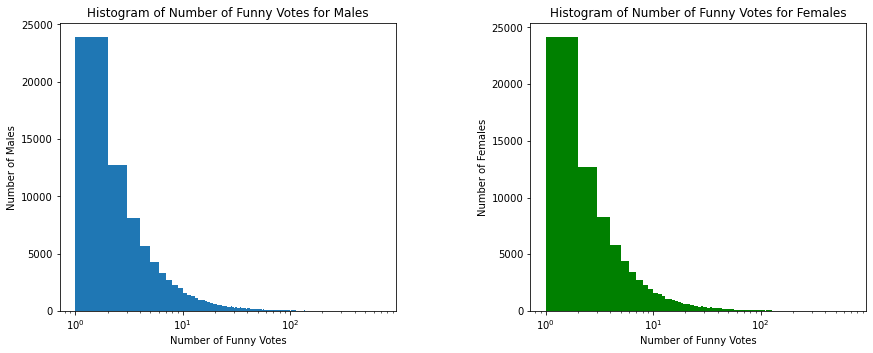

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.hist(funny_male.collect(),bins=range(1,700))
plt.title("Histogram of Number of Funny Votes for Males")
plt.xscale("log")
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Males')

plt.subplot(1, 2, 2)
plt.hist(funny_female.collect(),bins=range(1,700),color='g')
plt.title("Histogram of Number of Funny Votes for Females")
plt.xscale("log")
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Females')

plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

Both the plots (Number of Funny Votes for Men and Females) tend to follow the Power-Law relationship. 

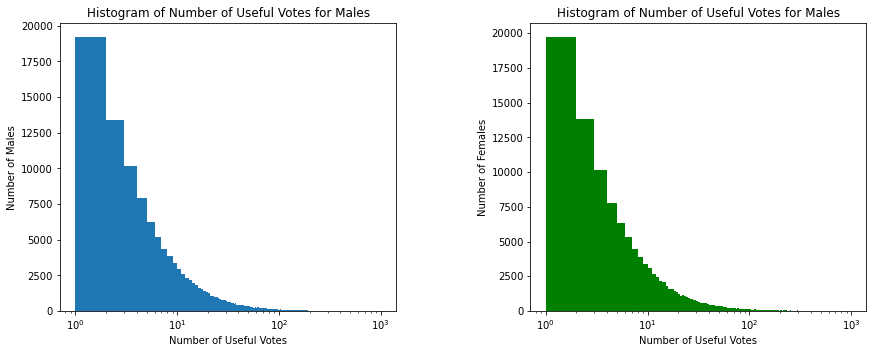

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.hist(useful_male.collect(),bins=range(1,1000))
plt.title("Histogram of Number of Useful Votes for Males")
plt.xscale("log")
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Males')

plt.subplot(1, 2, 2)
plt.hist(useful_female.collect(),bins=range(1,1000),color='g')
plt.title("Histogram of Number of Useful Votes for Males")
plt.xscale("log")
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Females')

plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

Both the plots (Number of Useful Votes for Men and Females) tend to follow the Power-Law relationship.

In [ ]:
males_funny_mean= funny_male.mean()
females_funny_mean= funny_female.mean()

males_useful_mean= useful_male.mean()
females_useful_mean= useful_female.mean()

d = {'Gender': ['males', 'females'], 'Mean Funny Votes': [males_funny_mean,females_funny_mean],'Mean Useful Votes': [males_useful_mean,females_useful_mean]}
df = pd.DataFrame(data=d)

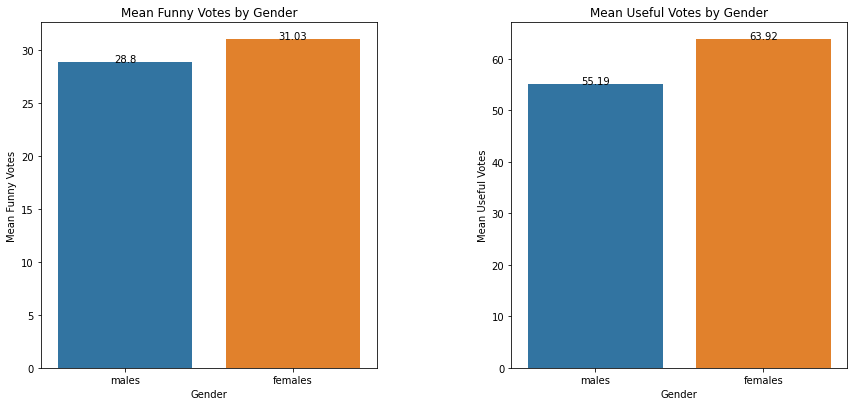

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
g=sns.barplot(x='Gender',y='Mean Funny Votes',data=df)
plt.title("Mean Funny Votes by Gender")


for index, row in df.iterrows():
    g.text(row.name,row['Mean Funny Votes'], str(round(row['Mean Funny Votes'],2)), color='black', ha="center")


plt.subplot(1, 2, 2)
g=sns.barplot(x='Gender',y='Mean Useful Votes',data=df)
plt.title("Mean Useful Votes by Gender")

for index, row in df.iterrows():
    g.text(row.name,row['Mean Useful Votes'], str(round(row['Mean Useful Votes'],2)), color='black', ha="center")


plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

#### Hence, we can say that females tend to increase the credibility of reviews on Yelp, which can help other users be more trustful of certain reviews while selecting amongst various restaurants, hotels, cafes etc.

####  More reviews that are voted as "useful" also reinforces the authenticity of a review, and enhances the general popularity of a brand/restaurant on Yelp.